In [131]:
import time

from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### Principal Components

$$ \mathbf{V} = \begin{pmatrix}
\mid & \mid &  & \mid \\ 
\mathbf{c}_{1} & \mathbf{c}_{2} & \dots & \mathbf{c}_{n} \\ 
\mid & \mid &  & \mid
\end{pmatrix} $$

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
c1

array([0.93636116, 0.29854881, 0.18465208])

In [5]:
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

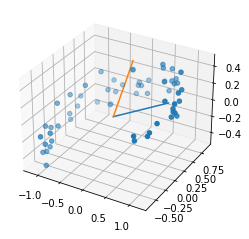

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2])
ax.plot(xs=[0, c1[0]], ys=[0, c1[1]], zs=[0, c1[2]])
ax.plot(xs=[0, c2[0]], ys=[0, c2[1]], zs=[0, c2[2]])
plt.show()

### Projecting Down to d Dimensions

$$ \mathbf{X}_{d-\mathrm{proj}} = \mathbf{XW}_{d} $$

In [26]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

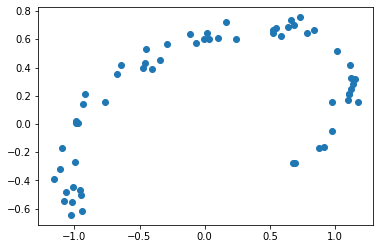

In [31]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

### Using Scikit-Learn

In [33]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [34]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [36]:
pca.components_.T[:, 0]

array([-0.93636116, -0.29854881, -0.18465208])

### Explained Variance Ratio

In [37]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### Choosing the Right Number of Dimensions

In [39]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [40]:
d

2

In [43]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

### PCA for compression

In [46]:
mnist = datasets.fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [47]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(mnist.data)

In [49]:
X_reduced.shape[1]

154

In [50]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(mnist.data)
X_recovered = pca.inverse_transform(X_reduced)

$$ \mathbf{X} = \mathbf{X}_{d-\mathrm{proj}}\mathbf{W}_{d}^{\top} $$

### Randomized PCA

In [51]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(mnist.data)

### Incremental PCA

In [53]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(mnist.data, n_batches):
    inc_pca.partial_fit(X_batch)

In [54]:
X_reduced = inc_pca.transform(mnist.data)

In [60]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'newfile.dat')

X_mm = np.memmap(filename, dtype='float32', mode='w+', shape=mnist.data.shape)
X_mm[:] = mnist.data[:]

batch_size = len(mnist.data) // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=700, n_components=154)

### Kernel PCA

In [62]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### Selecting a Kernel and Tuning Hyperparameters

In [68]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

In [64]:
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

In [65]:
param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

In [66]:
grid_search = GridSearchCV(clf, param_grid, cv=3)

In [69]:
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [70]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [73]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [75]:
mean_squared_error(X, X_preimage)

1.413663740187471e-26

### LLE

In [78]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

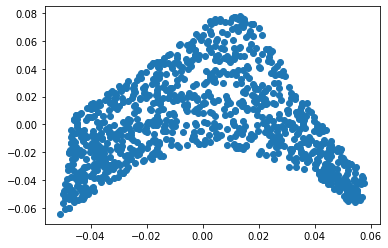

In [79]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.show()

$$ \widehat{\mathbf{W}} = \underset{\mathbf{W}}{\mathrm{argmin}} \sum_{i = 1}^{m}\left ( \mathbf{x}^{(i)} - \sum_{j = 1}^{m} w_{i, j}\mathbf{x}^{(j)} \right )^{2} $$

$$
\mathrm{subject\ to} \left\{\begin{matrix}
w_{i, j} = 0\ \mathrm{if\ } \mathbf{x}^{(j)}\ \mathrm{is\ not\ one\ of\ the\ }k\ \mathrm{c.n.\ of\ } \mathbf{x}^{(i)}
\\ \sum_{j = 1}^{m}w_{i, j} = 1\ \mathrm{for\ } i = 1, 2, ..., m
\end{matrix}\right.
$$

$$ \widehat{\mathbf{Z}} = \underset{\mathbf{Z}}{\mathrm{argmin}} \sum_{i = 1}^{m}\left ( \mathbf{z}^{(i)} - \sum_{j = 1}^{m} \widehat{w}_{i, j}\mathbf{z}^{(j)} \right )^{2} $$

### Exercises

#### 9.

In [80]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [83]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [86]:
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [87]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 49.08s


In [89]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [92]:
pca = PCA(n_components=0.95) # 95% explained variance ratio
X_train_reduced = pca.fit_transform(X_train)

In [93]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [94]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 106.23s


In [95]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [96]:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 55.58s


In [98]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [99]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 12.86s


In [101]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

#### 10.

In [104]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'].loc[idx]
y = mnist['target'].loc[idx]

In [106]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

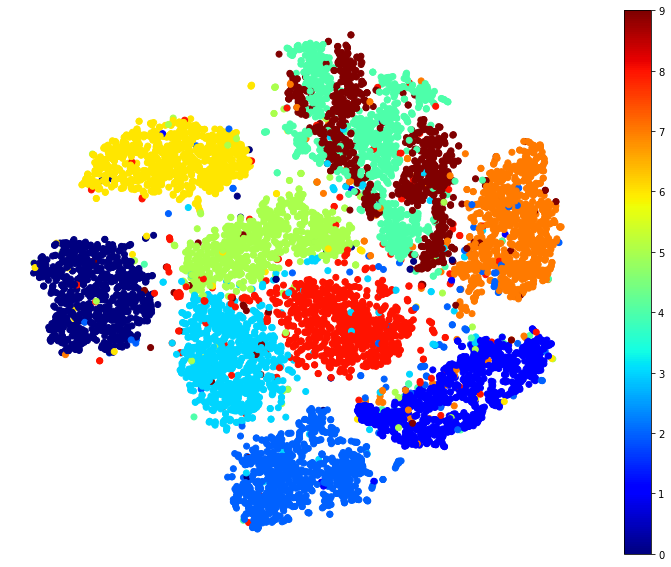

In [107]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

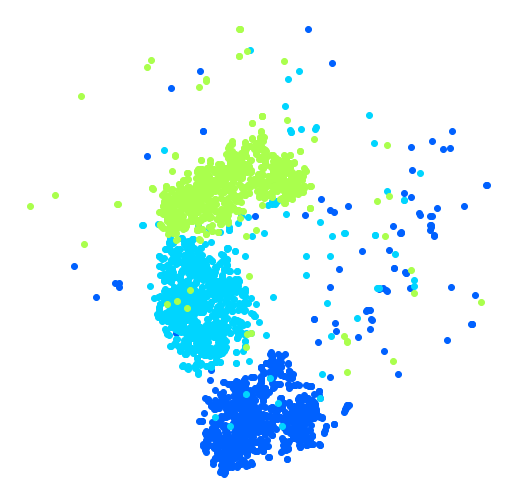

In [110]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [111]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

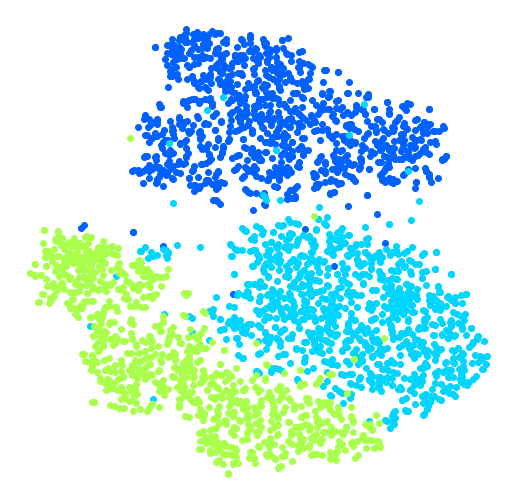

In [112]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [114]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = mpl.offsetbox.AnnotationBbox(mpl.offsetbox.OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

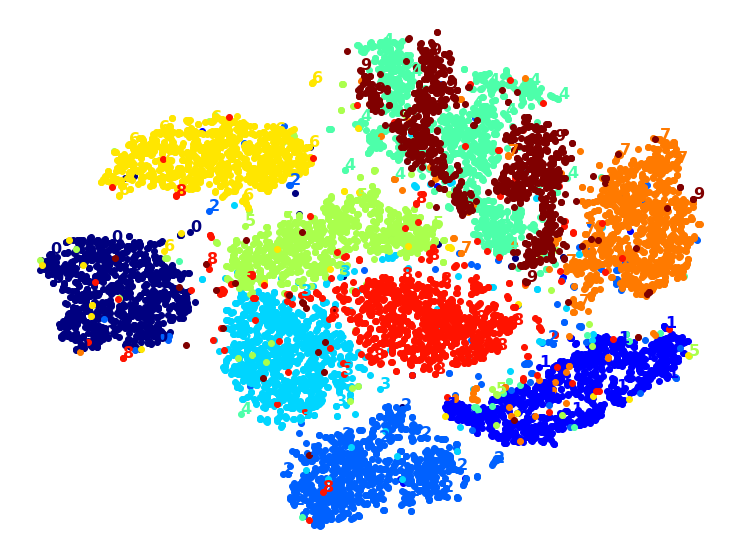

In [118]:
plot_digits(X_reduced, y.values)

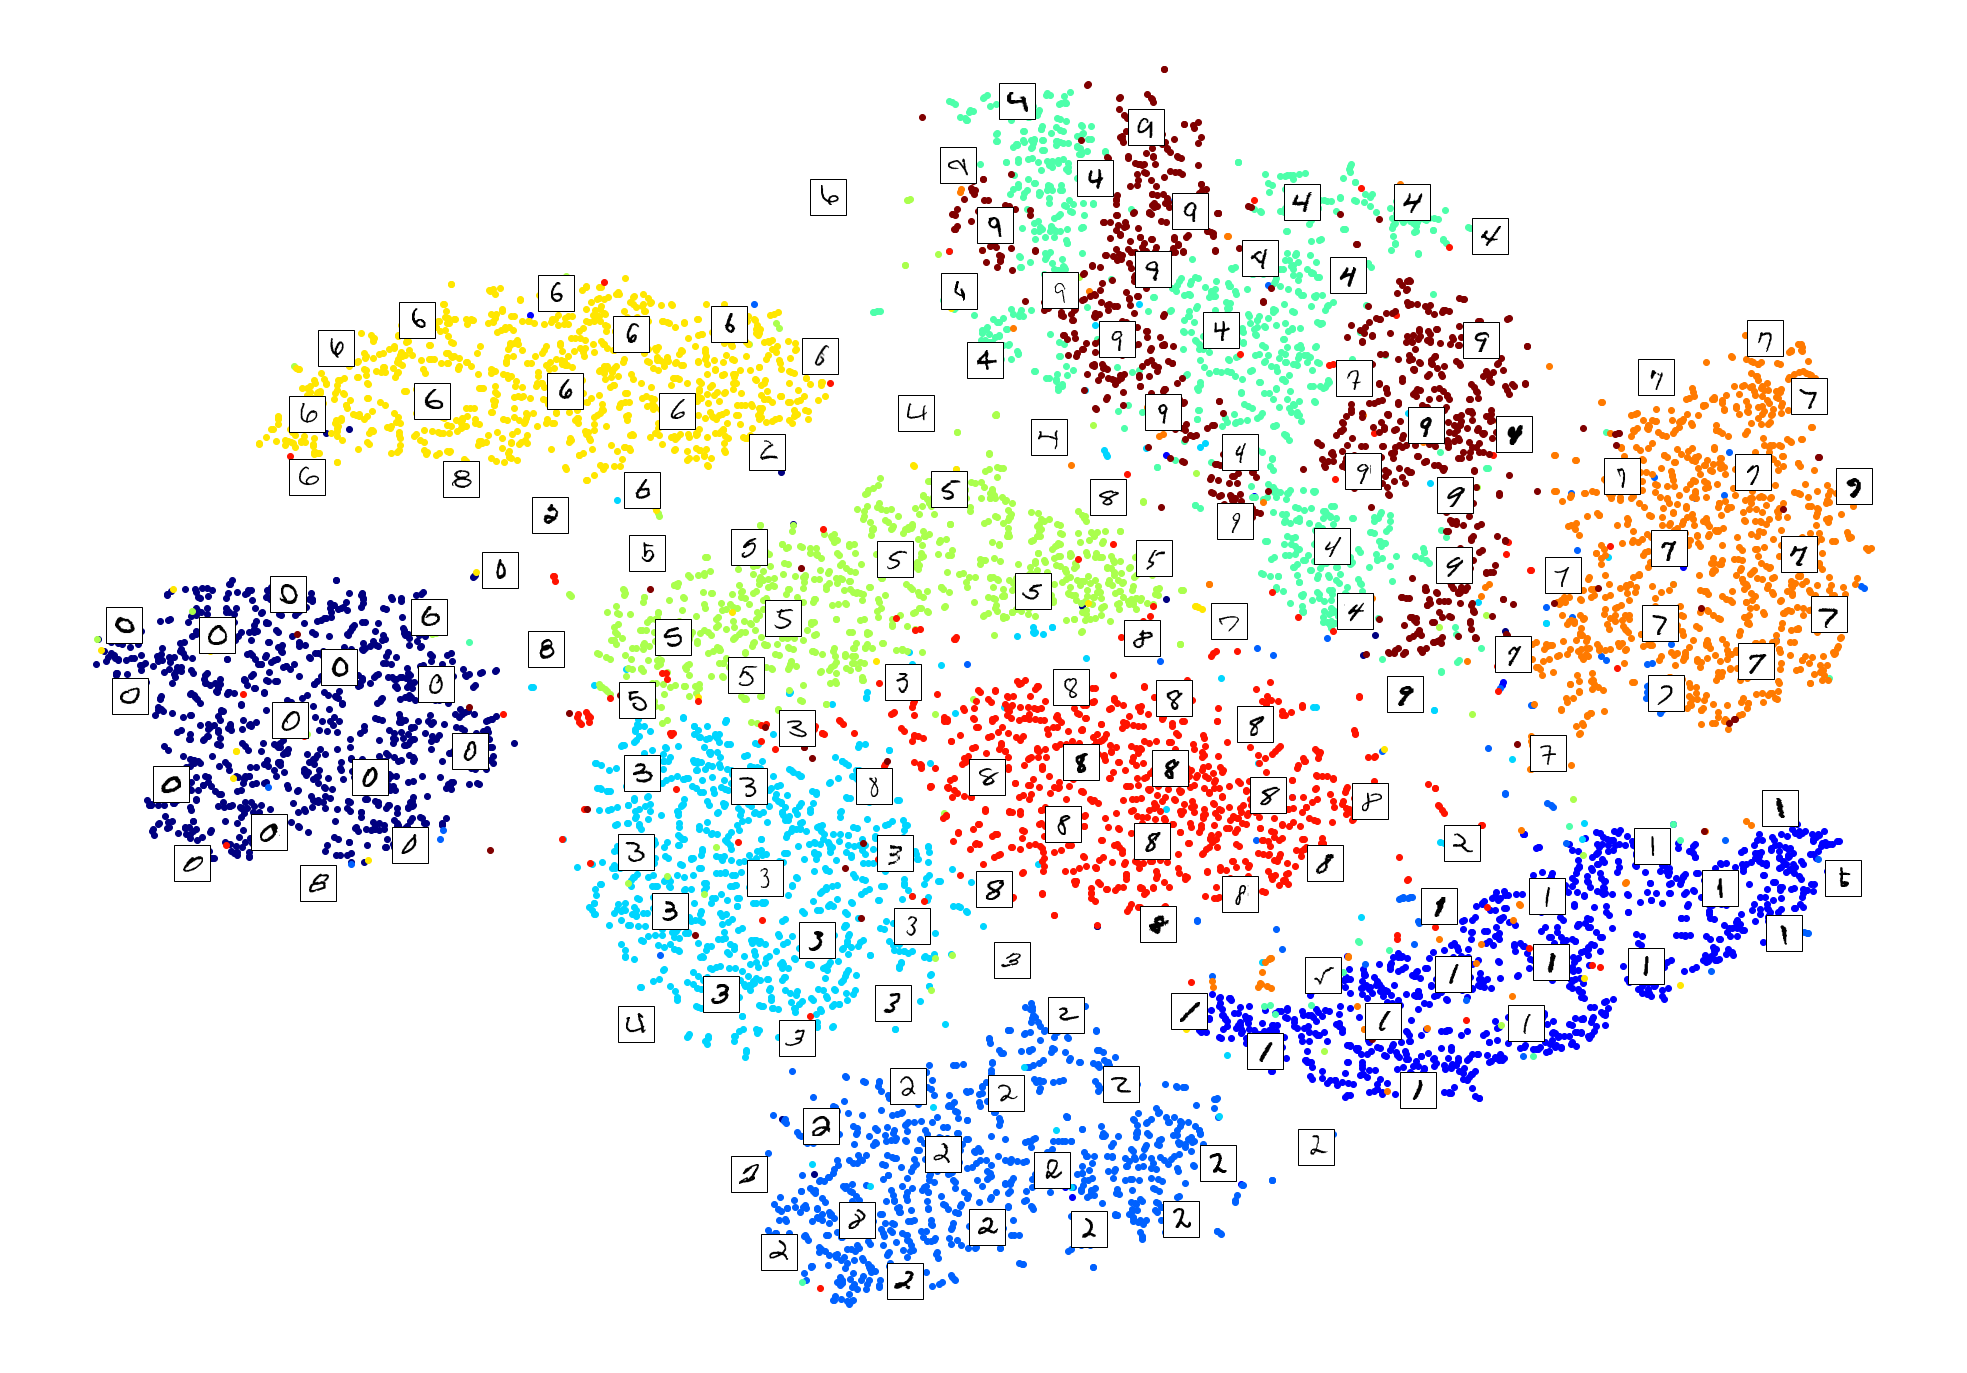

In [121]:
plot_digits(X_reduced, y.values, images=X.values, figsize=(35, 25))

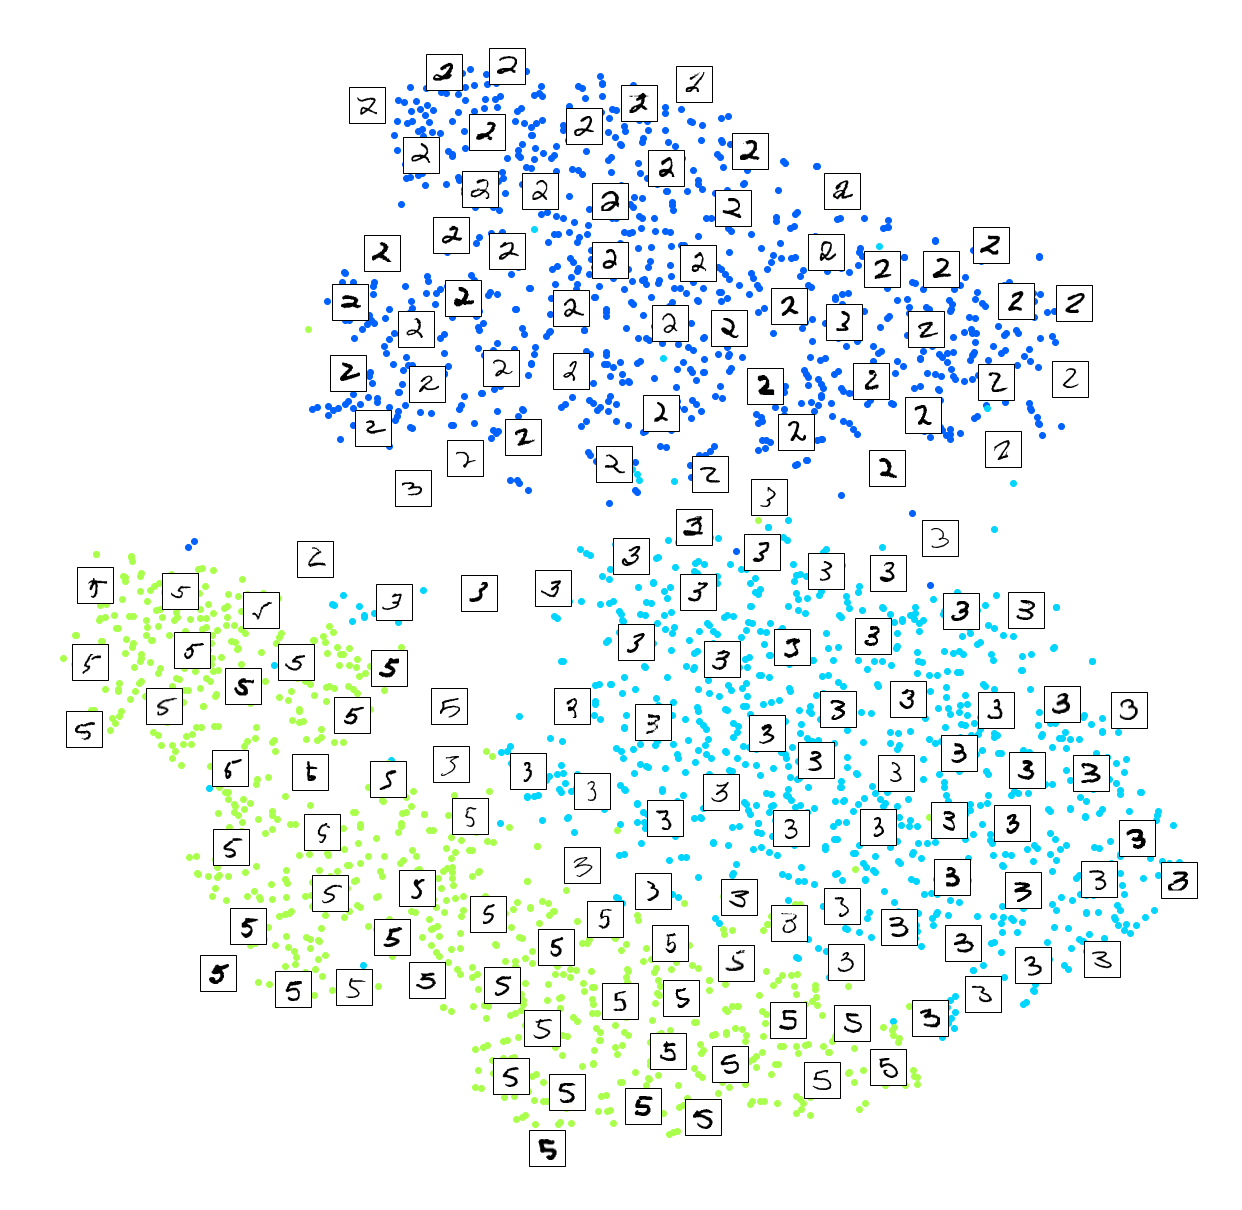

In [123]:
plot_digits(X_subset_reduced, y_subset.values, images=X_subset.values, figsize=(22, 22))

PCA took 0.6s.


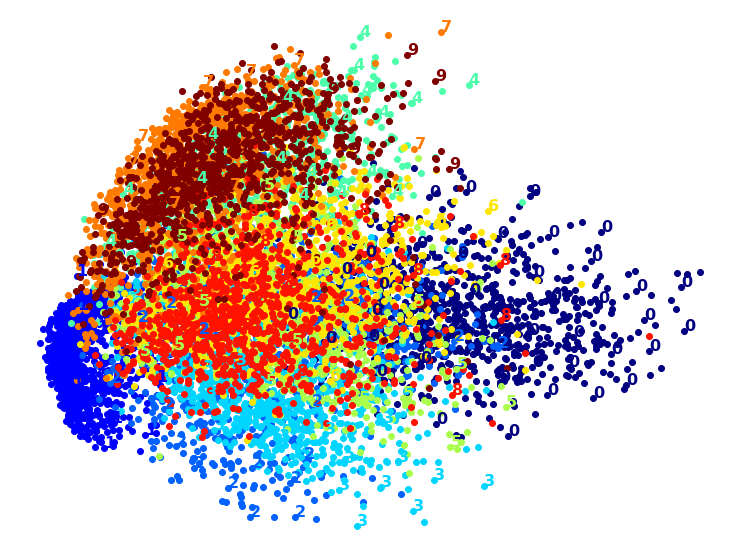

In [125]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y.values)
plt.show()

LLE took 31.6s.


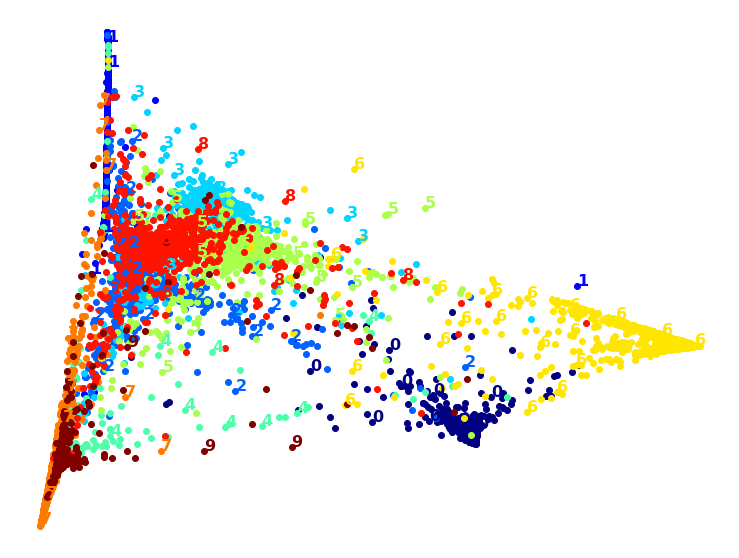

In [126]:
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y.values)
plt.show()

PCA+LLE took 44.7s.


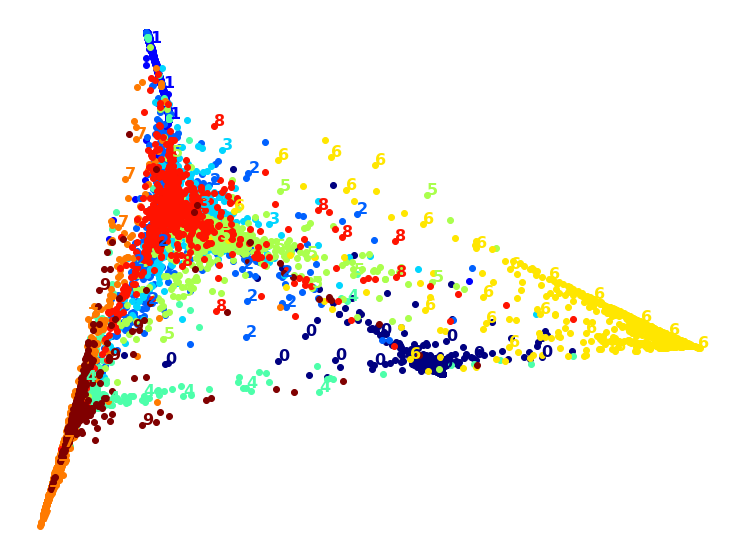

In [127]:
pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y.values)
plt.show()

MDS took 165.0s (on just 2,000 MNIST images instead of 10,000).


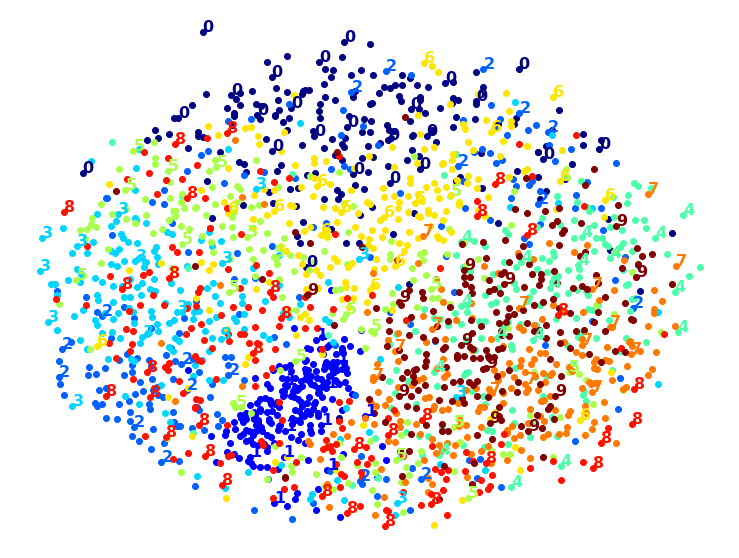

In [129]:
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X.values[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y.values[:m])
plt.show()

PCA+MDS took 170.6s (on 2,000 MNIST images).


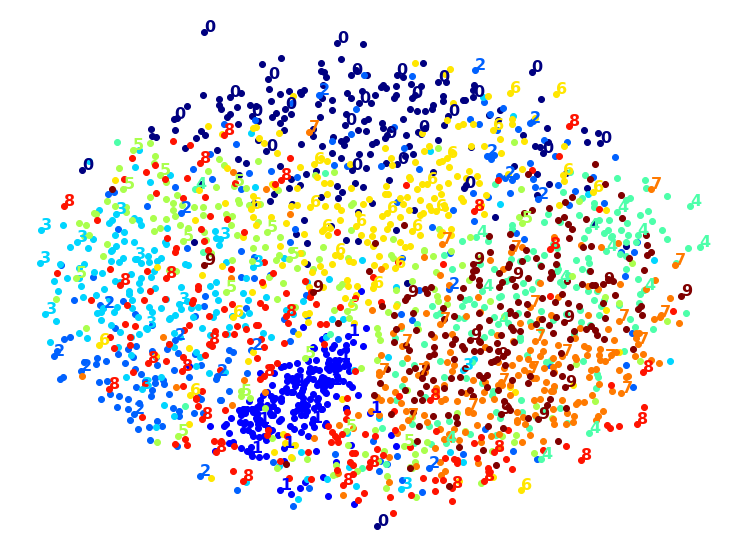

In [130]:
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X.values[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y.values[:2000])
plt.show()

LDA took 2.5s.


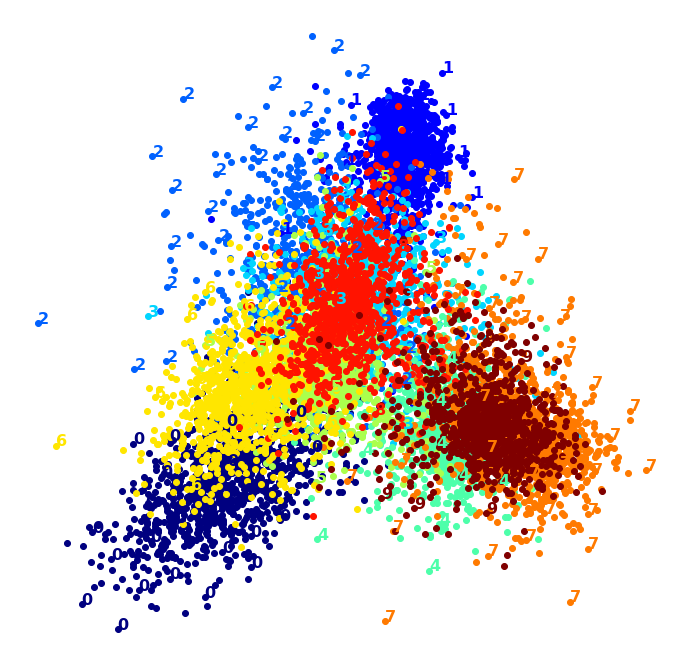

In [132]:
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y.values, figsize=(12,12))
plt.show()

t-SNE took 77.2s.


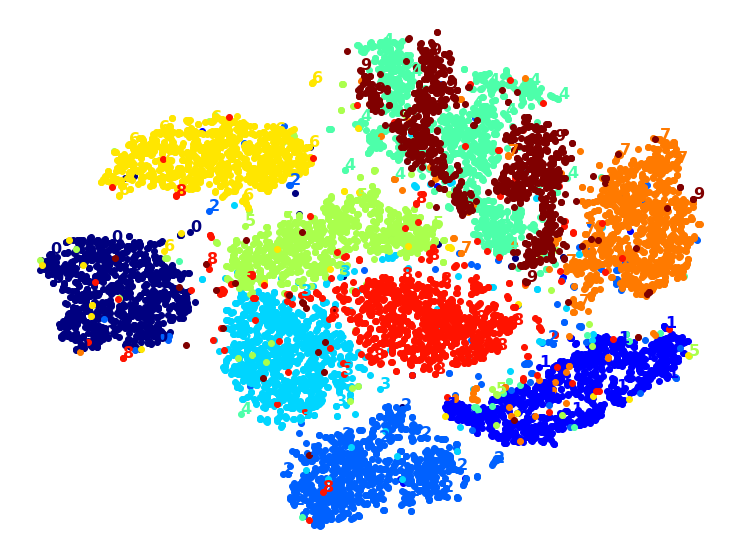

In [133]:
t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y.values)
plt.show()

PCA+t-SNE took 78.1s.


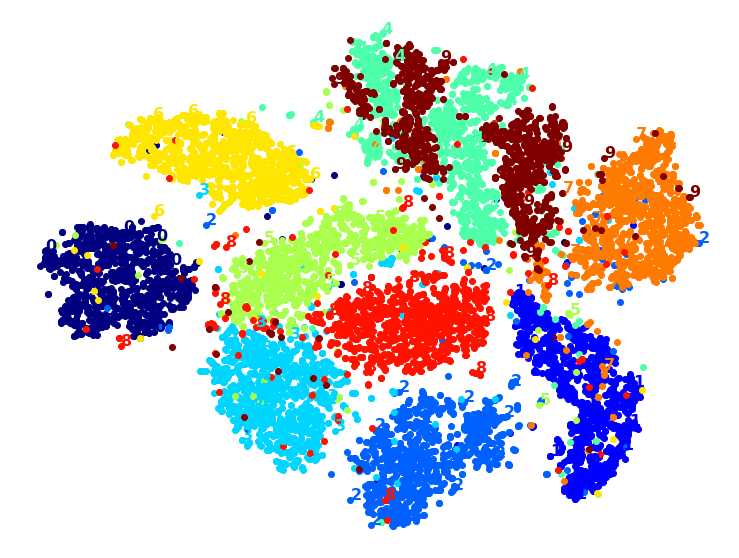

In [134]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y.values)
plt.show()